In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
import pickle as pkl
import string
from itertools import cycle
import matplotlib.gridspec as gridspec


In [2]:
plt.style.use(r'C:\Users\Simon Syga\PycharmProjects\biolgca\nature_style.mplstyle')
PATH = '.\\data\\gog\\nonlocaldensity_10reps\\'
parameters = np.load(PATH+'params.npz', allow_pickle=True)
constparams = parameters['constparams'].item()
r_ds = parameters['r_ds']
thetas = parameters['thetas']
reps = 10
# data = np.load(PATH+'n_pr.npy', allow_pickle=True)
stepsize = 1

In [3]:
def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    Walks through axes and labels each.

    kwargs are collected and passed to `annotate`

    Parameters
    ----------
    fig : Figure
         Figure object to work on

    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.

    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_uppercase

    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (-0.05, 1.15)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc, ha='right', weight='bold', xycoords='axes fraction', **kwargs)

In [39]:
def plot_migr_rest_spatiotemp(index, reps, lgca, PATH):
    nodes_t = np.empty((constparams['tmax'], constparams['l'], 3), dtype=object)
    lgca.props = {}
    migrating_cells = []
    resting_cells = []
    for i in range(reps):
        p = PATH + 'data{}.pkl'.format(index + (i, 0,))
        with open(p, 'rb') as f:
            d = pkl.load(f)

        lgca.nodes = d['nodes_t']
        lgca.update_dynamic_fields()
        m = lgca.channel_pop[:, :lgca.velocitychannels].sum(-1)
        migrating_cells.append(m)
        resting_cells.append(lgca.cell_density - m)

    mean_migrating_cells = np.mean(migrating_cells, axis=0)
    std_migration = np.std(migrating_cells, axis=0) / np.sqrt(reps)
    mean_resting_cells = np.mean(resting_cells, axis=0)
    std_resting = np.std(resting_cells, axis=0) / np.sqrt(reps)
    plt.plot(mean_resting_cells, label='Proliferating')
    plt.fill_between(np.arange(len(mean_resting_cells)), mean_resting_cells - std_resting,
                     mean_resting_cells + std_resting, alpha=.5)
    plt.plot(mean_migrating_cells, label='Migrating')
    plt.fill_between(np.arange(len(mean_migrating_cells)), mean_migrating_cells - std_migration,
                     mean_migrating_cells + std_migration, alpha=.5)

In [111]:
def plot_kappa_spatiotemp(index, reps, lgca, PATH):
    from matplotlib.collections import LineCollection
    mean_props = []
    for i in range(reps):
        p = PATH+'data{}.pkl'.format(index+(i, 0,))
        with open(p, 'rb') as f:
            d = pkl.load(f)
            mean_props.append(lgca.calc_prop_mean(d['nodes_t'], propname='kappa', props={'kappa': d['kappa']}))

    # len(mean_props)
    mean_props = np.ma.array(mean_props)

    mean_prop = np.mean(mean_props, axis=0)
    std_prop = np.std(mean_props, axis=0)  # calculate the standard deviation of the mean
    # n_sample = np.sum(~mean_props.mask, axis=0)  # calculate the number of samples
    # std_mean = std_prop / np.sqrt(n_sample)  # calculate the standard error of the mean
    # Define the window size for the running average
    # window_size = 5

    # Define the weights for the running average
    # weights = np.repeat(1.0, window_size) / window_size

    # Apply the running average using convolution
    # running_average_prop = np.convolve(mean_prop, weights, 'same')
    # std_running_average_prop = np.convolve(std_prop, weights, 'same')
    # running_average_prop = np.ma.array(running_average_prop, mask=mean_prop.mask)
    # std_running_average_prop = np.ma.array(std_running_average_prop, mask=mean_prop.mask)
    x = np.arange(len(mean_prop))
    y_masked = mean_prop
    # ax.plot(np.ma.array(mean_props).T, color='k', alpha=0.5, lw=.5)
    plt.plot([0, len(mean_prop)], [0, 0], 'k--')
    # plt.plot(mean_prop, lw=1, color=mean_prop, cmap='coolwarm', vmin=-5, vmax=5)
    # # fill the area between the mean and the standard deviation
    # plt.fill_between(np.arange(len(mean_prop)), mean_prop-std_prop, mean_prop+std_prop, alpha=.5)
    y_err = std_prop
    points = np.array([x, y_masked]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a colormap to color the line based on y-position
    cmap = plt.get_cmap('coolwarm')

    # Normalize the y values to a range between 0 and 1 for the colormap
    norm = plt.Normalize(-5, 5)

    # Create a LineCollection object
    lc = LineCollection(segments, cmap=cmap, norm=norm)

    # Set the LineCollection's y values as color values
    lc.set_array(y_masked)
    ax = plt.gca()
    # Add the LineCollection to the plot
    for i in range(len(x) - 1):
        if not y_masked.mask[i]:
            plt.fill_between([x[i]-.5, x[i]+.5], y_masked[i] - y_err[i], y_masked[i] + y_err[i],
                             color=cmap(norm(y_masked[i])), alpha=0.25)

    ax.add_collection(lc)
    # plt.plot(running_average_prop)
    # plt.fill_between(np.arange(len(mean_prop)), running_average_prop-std_running_average_prop, running_average_prop+std_running_average_prop, alpha=.5)

In [6]:
restchannels = 1
l = 1001
dims = l, l
capacity = 100
# interaction parameters
r_b = 1. # initial birth rate
# r_d = 0.2 # initial death rate
nodes = np.zeros((l,)+(2+restchannels,), dtype=int)
nodes[l//2, -1] = capacity
kappa = np.random.random(capacity) * 8 - 4

In [7]:
with open('lgca1.pkl', 'rb') as f:
    lgca1 = pkl.load(f)

with open('lgca2.pkl', 'rb') as f:
    lgca2 = pkl.load(f)

with open('lgca3.pkl', 'rb') as f:
    lgca3 = pkl.load(f)

In [8]:
# lgca1 = get_lgca(ib=True, bc='reflect', interaction='go_or_grow_kappa', dims=l, nodes=nodes, ve=False, geometry='lin',
#                 r_b=r_b, capacity=capacity, r_d=0., kappa=kappa, theta=.2, kappa_std=.2)
#
# lgca1.timeevo(1000, record=True, recordN=False)
# with open('lgca1.pkl', 'wb') as f:
#     pkl.dump(lgca1, f)
# lgca = pkl.load(open('example_lgca.pkl', 'rb'))

In [9]:
# lgca2 = get_lgca(ib=True, bc='reflect', interaction='go_or_grow_kappa', dims=l, nodes=nodes, ve=False, geometry='lin',
#                 r_b=r_b, capacity=capacity, r_d=0.2, kappa=kappa, theta=.2, kappa_std=.2)
#
# lgca2.timeevo(1000, record=True, recordN=False)
# with open('lgca2.pkl', 'wb') as f:
#     pkl.dump(lgca2, f)

In [10]:
# lgca3 = get_lgca(ib=True, bc='reflect', interaction='go_or_grow_kappa', dims=l, nodes=nodes, ve=False, geometry='lin',
#                 r_b=r_b, capacity=capacity, r_d=0.2, kappa=kappa, theta=1., kappa_std=.2)
#
# lgca3.timeevo(1000, record=True, recordN=False)
# with open('lgca3.pkl', 'wb') as f:
#     pkl.dump(lgca3, f)



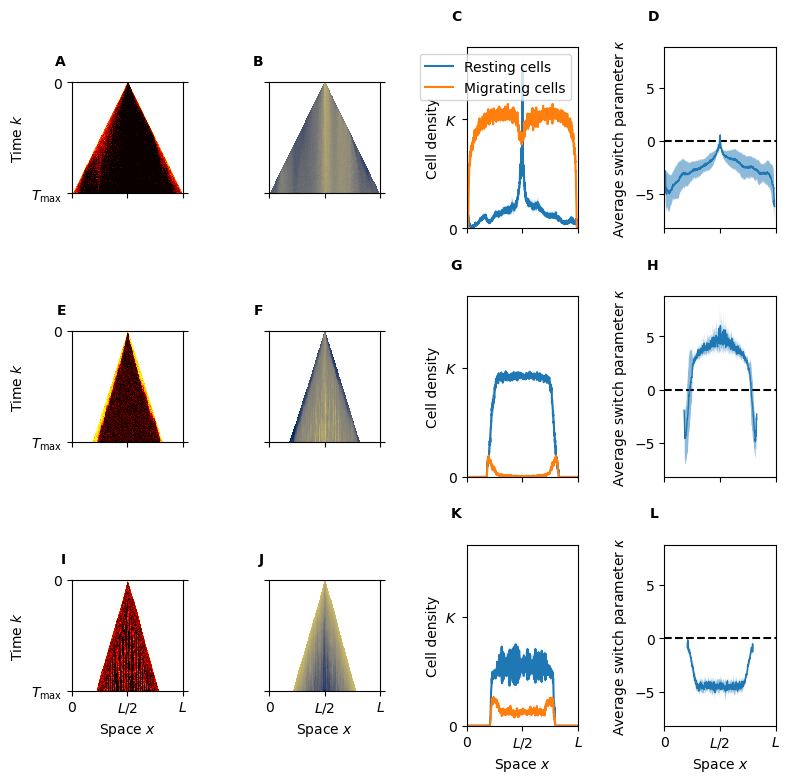

In [ ]:
# get figsize from style
figsize = 7.086614, 8.858268
fig, axes = plt.subplots(3, 4, sharex=True, sharey='col', figsize=figsize)
plt.sca(axes[0, 0])
ax = axes[0, 0]
lgca1.plot_density(absolute_max=100, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'Time $k$')
ax.set_yticks([0, 1000], [0, '$T_{\mathrm{max}}$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')

plt.sca(axes[0, 1])
ax = axes[0, 1]
lgca1.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', cbar=False)
plt.ylabel(r'')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')
plt.yticks([0, 1000], ['', ''])

plt.sca(axes[1, 0])
ax = axes[1, 0]
lgca2.plot_density(absolute_max=100, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'Time $k$')
ax.set_yticks([0, 1000], [0, '$T_{\mathrm{max}}$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')

plt.sca(axes[1, 1])
ax = axes[1, 1]
lgca2.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', cbar=False)
plt.ylabel(r'')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')
plt.yticks([0, 1000], ['', ''])

plt.sca(axes[2, 0])
ax = axes[2, 0]
lgca3.plot_density(absolute_max=100, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'Time $k$')
plt.xlabel(r'Space $x$')
ax.set_yticks([0, 1000], [0, '$T_{\mathrm{max}}$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

plt.sca(axes[2, 1])
ax = axes[2, 1]
lgca3.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', cbar=False)
plt.ylabel(r'')
plt.xlabel(r'Space $x$')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.yticks([0, 1000], ['', ''])


ax.set_xticks([0, 500, 1001], [0, r'$L/2$', '$L$'])


index = 0, 2
plt.sca(axes[0, 2])
plot_migr_rest_spatiotemp(index, reps, lgca1, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')
plt.sca(axes[0, 3])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])

index = (4, 2)
plt.sca(axes[1, 2])
plot_migr_rest_spatiotemp(index, reps, lgca1, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.sca(axes[1, 3])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])

index = (4, 8)
plt.sca(axes[2, 2])
plot_migr_rest_spatiotemp(index, reps, lgca1, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.xlabel(r'Space $x$')
plt.sca(axes[2, 3])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.xlabel(r'Space $x$')
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])

label_axes(fig)
plt.tight_layout()
# plt.savefig(r'goorgrow/figures/cell_density_and_local_kappa.svg')
# plt.savefig(r'goorgrow/figures/cell_density_and_local_kappa.pdf')


In [83]:
%matplotlib inline

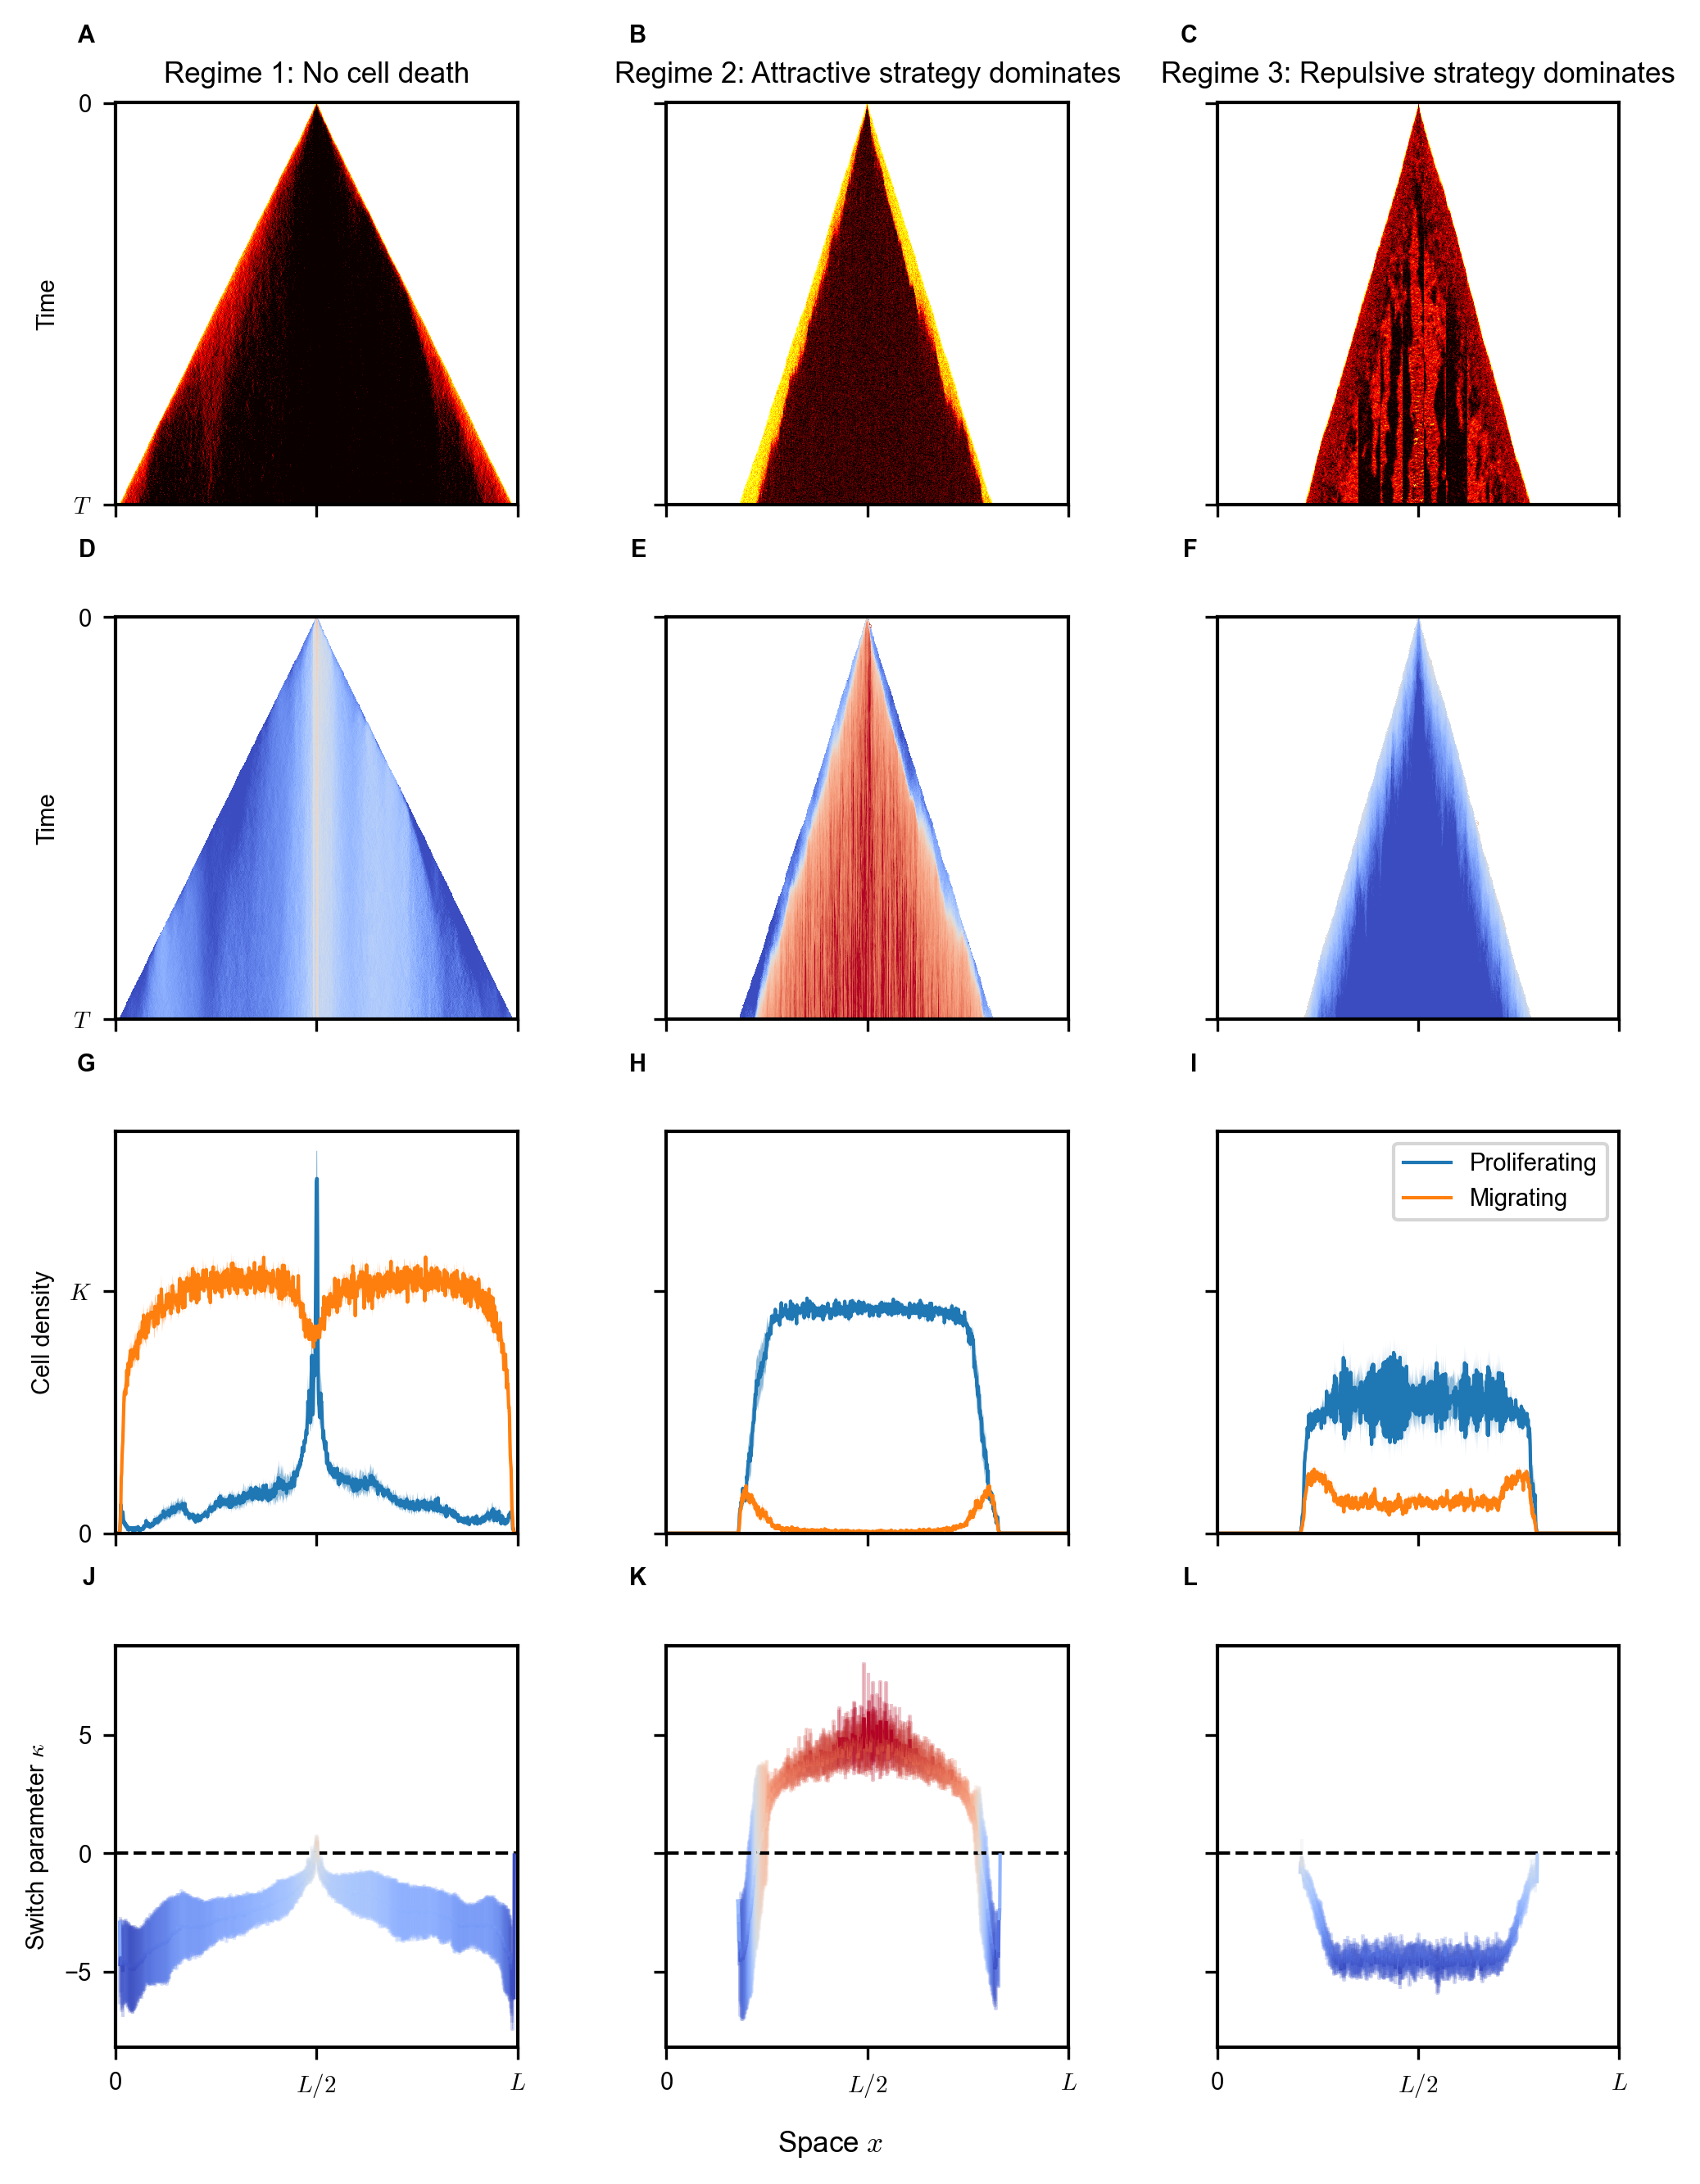

In [122]:
plt.style.use('nature_style.mplstyle')
figsize = 7.086614, 8.858268  # max figsize
# figsize = 3.464567, 8.661417 # max figsize 1 column
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey='row', figsize=figsize)
extent = [-0.5, 1000.5, 1000.5, -0.5]
# -------- density plots ---------
plt.sca(axes[0, 0])
ax = axes[0, 0]
ax.imshow(lgca1.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
plt.ylabel(r'Time')
plt.title('Regime 1: No cell death')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
plt.xlabel('')
# plt.ylabel('')

plt.sca(axes[0, 1])
ax = axes[0, 1]
plt.title('Regime 2: Attractive strategy dominates')
ax.imshow(lgca2.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
plt.ylabel('')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
plt.xlabel('')

plt.sca(axes[0, 2])
ax = axes[0, 2]
plt.title('Regime 3: Repulsive strategy dominates')
ax.imshow(lgca3.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
ax.xaxis.tick_bottom()
plt.ylabel('')
ax.set_yticks([0, 1000], [0, '$T$'])

plt.xlabel('')

# -------- kappa plots ---------

plt.sca(axes[1, 0])
ax = axes[1, 0]
lgca1.calc_prop_mean_spatiotemp()  if lgca1.mean_prop_t == {} else None

mean_prop_t = lgca1.mean_prop_t['kappa']

plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
# lgca1.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', cbar=False)
plt.ylabel(r'Time')
plt.xlabel('')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()


plt.sca(axes[1, 1])
ax = axes[1, 1]
lgca2.calc_prop_mean_spatiotemp()  if lgca2.mean_prop_t == {} else None

mean_prop_t = lgca2.mean_prop_t['kappa']

plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
plt.ylabel(r'')
plt.xlabel('')
plt.yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

plt.sca(axes[1, 2])
ax = axes[1, 2]
lgca3.calc_prop_mean_spatiotemp()  if lgca3.mean_prop_t == {} else None

mean_prop_t = lgca3.mean_prop_t['kappa']

plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
plt.ylabel(r'')
# ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.xlabel('')
plt.yticks([0, 1000], [0, '$T$'])


# -------- phenotype plots ---------

index = (0, 2)
plt.sca(axes[2, 0])
plot_migr_rest_spatiotemp(index, reps, lgca1, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)


index = (4, 2)
plt.sca(axes[2, 1])
plot_migr_rest_spatiotemp(index, reps, lgca2, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)

index = (4, 8)
plt.sca(axes[2, 2])
plot_migr_rest_spatiotemp(index, reps, lgca3, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')

# -------- kappa spatial plots ---------
index = (4, 8)
plt.sca(axes[3, 2])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)

plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])

index = (4, 2)
plt.sca(axes[3, 1])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])

index = (0, 2)
plt.sca(axes[3, 0])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])
plt.ylabel(r'Switch parameter $\kappa$')
plt.yticks(ticks=[-5, 0, 5])

label_axes(fig)
for ax in axes.flat:
    ax.set_box_aspect(1)

# set supxlabel
fig.supxlabel(r'Space $x$')
plt.tight_layout()
plt.savefig('regimes.svg', bbox_inches='tight')

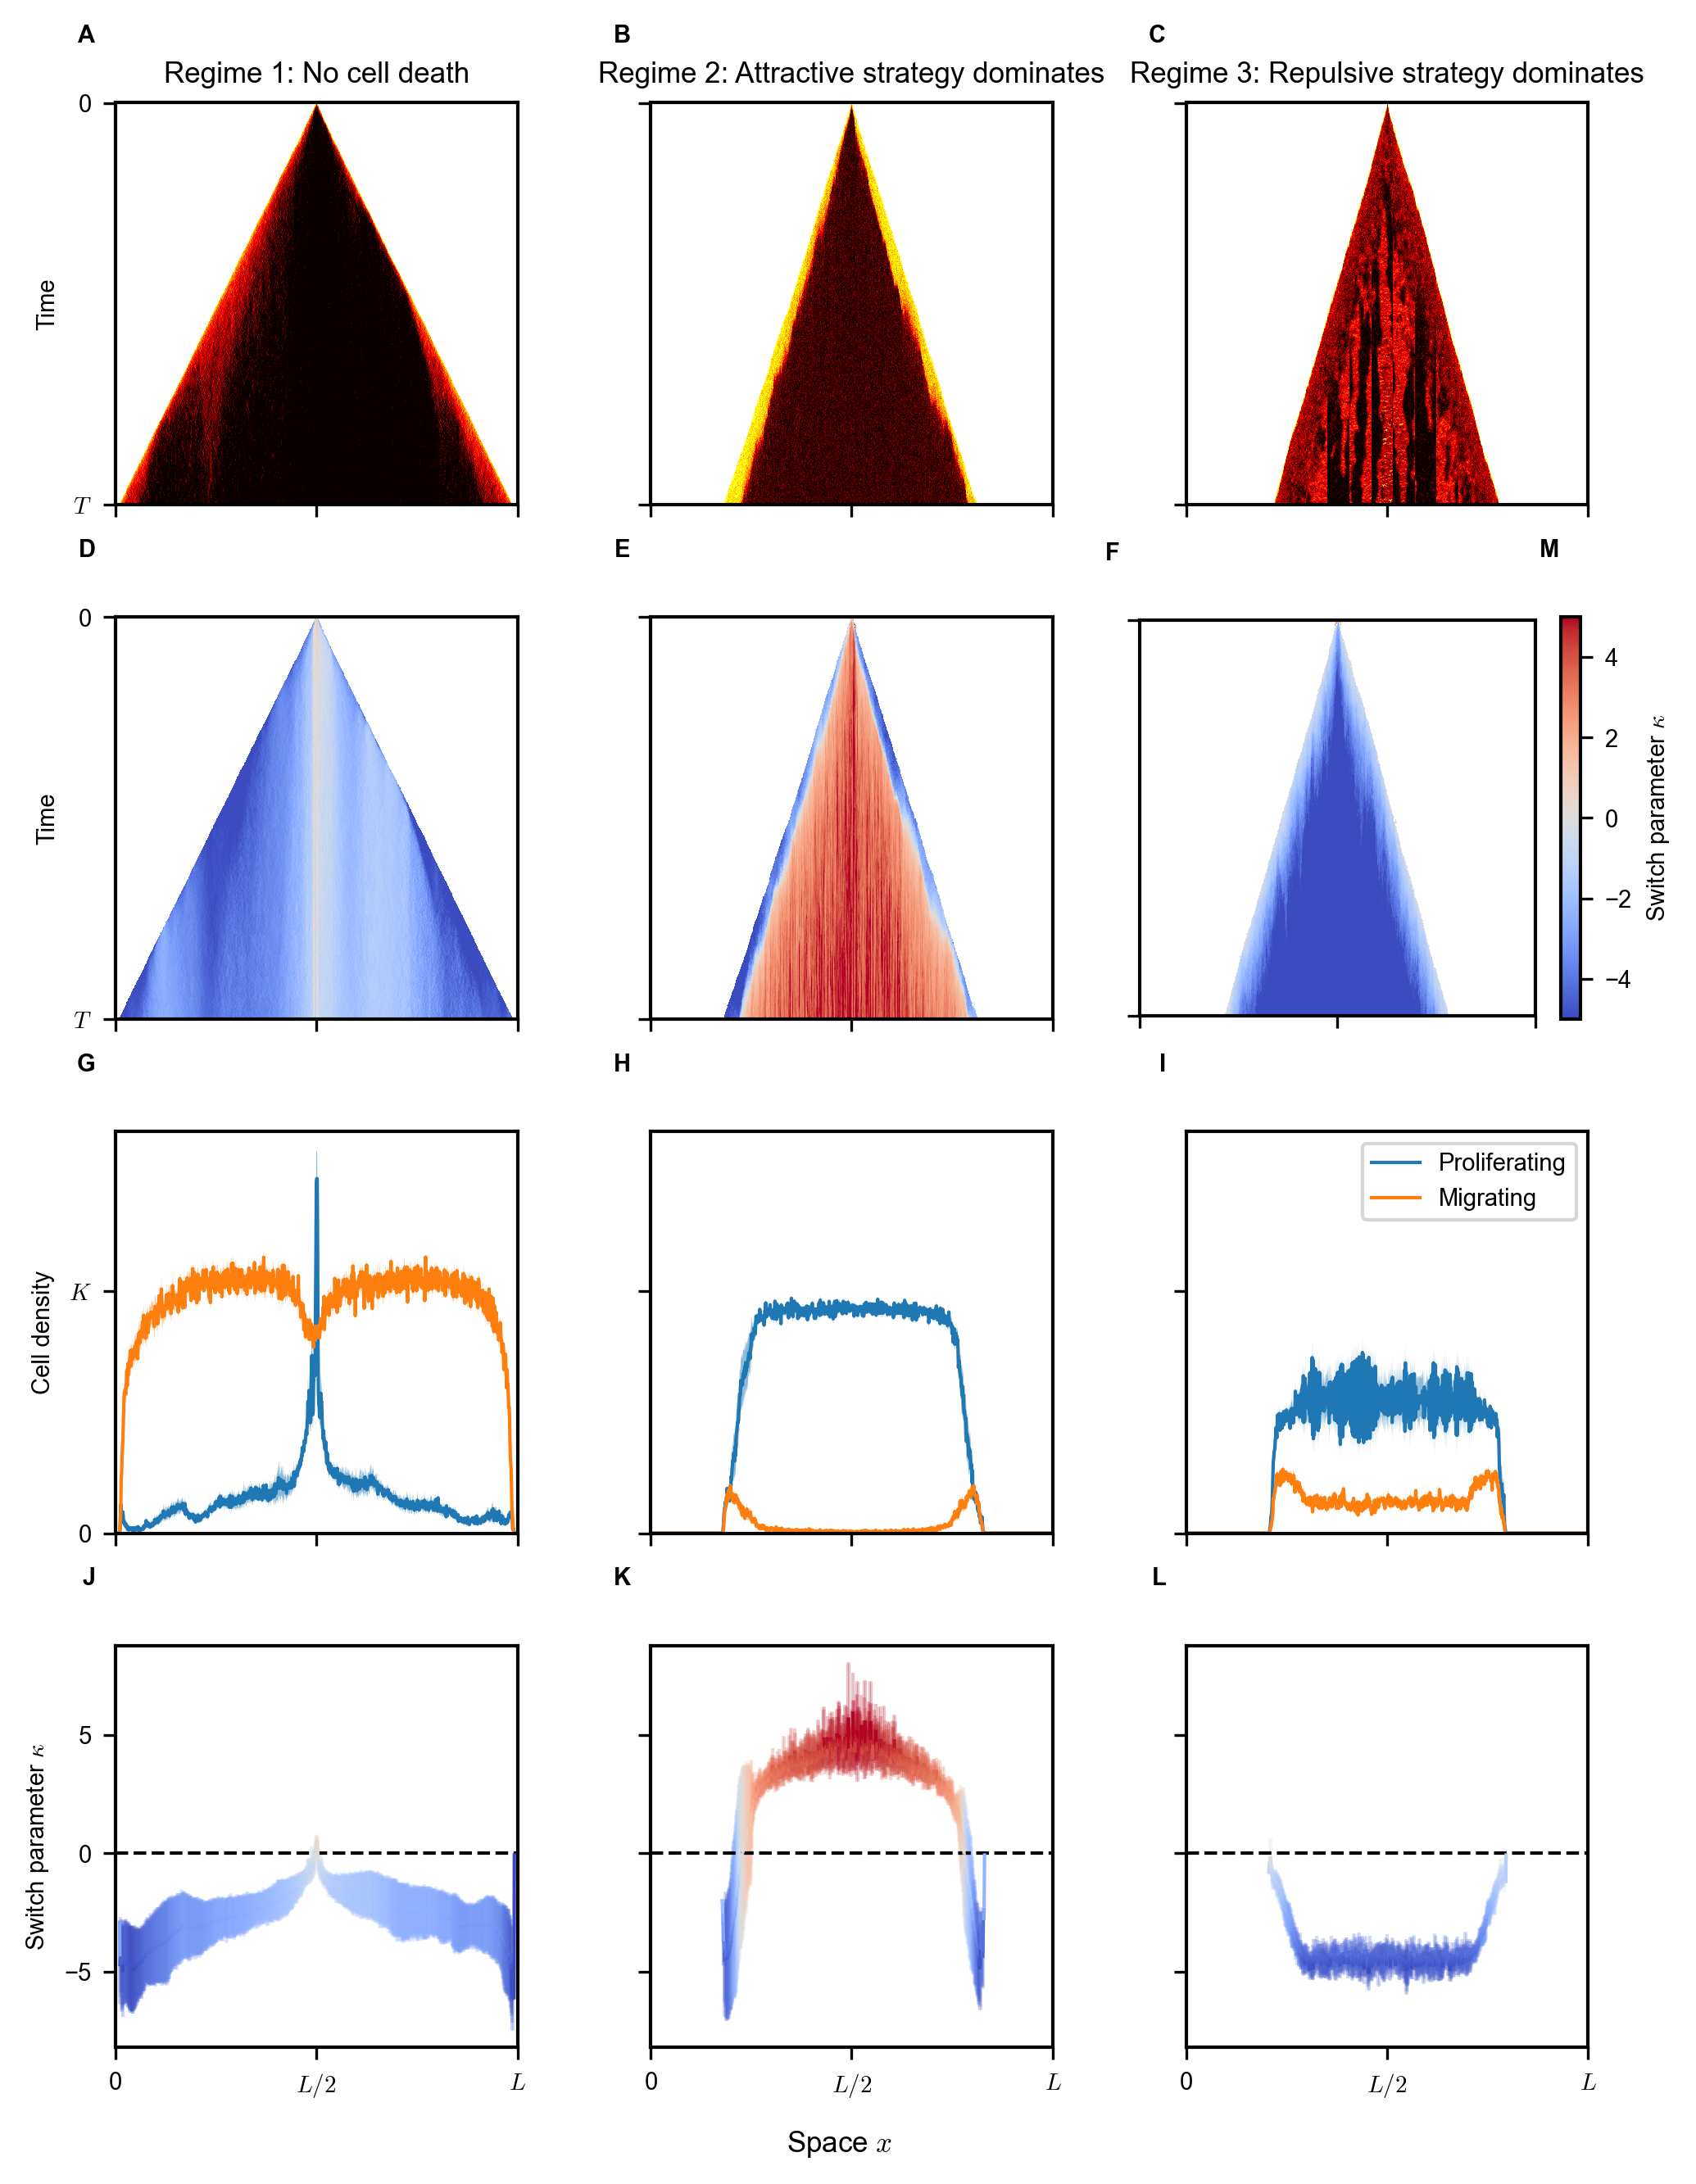

In [123]:
plt.style.use('nature_style.mplstyle')
figsize = 7.086614, 8.858268  # max figsize
# figsize = 3.464567, 8.661417 # max figsize 1 column
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey='row', figsize=figsize)
extent = [-0.5, 1000.5, 1000.5, -0.5]
# -------- density plots ---------
plt.sca(axes[0, 0])
ax = axes[0, 0]
ax.imshow(lgca1.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
plt.ylabel(r'Time')
plt.title('Regime 1: No cell death')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
plt.xlabel('')
# plt.ylabel('')

plt.sca(axes[0, 1])
ax = axes[0, 1]
plt.title('Regime 2: Attractive strategy dominates')
ax.imshow(lgca2.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
plt.ylabel('')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
plt.xlabel('')

plt.sca(axes[0, 2])
ax = axes[0, 2]
plt.title('Regime 3: Repulsive strategy dominates')
im = ax.imshow(lgca3.dens_t, interpolation='None', vmin=0, vmax=100, cmap='hot_r', extent=extent)
ax.xaxis.tick_bottom()
plt.ylabel('')
ax.set_yticks([0, 1000], [0, '$T$'])
# plt.colorbar(im, label=r'Cell density')

plt.xlabel('')

# -------- kappa plots ---------

plt.sca(axes[1, 0])
ax = axes[1, 0]
lgca1.calc_prop_mean_spatiotemp()  if lgca1.mean_prop_t == {} else None

mean_prop_t = lgca1.mean_prop_t['kappa']

plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
# lgca1.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', cbar=False)
plt.ylabel(r'Time')
plt.xlabel('')
ax.set_yticks([0, 1000], [0, '$T$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()


plt.sca(axes[1, 1])
ax = axes[1, 1]
lgca2.calc_prop_mean_spatiotemp()  if lgca2.mean_prop_t == {} else None

mean_prop_t = lgca2.mean_prop_t['kappa']

plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
plt.ylabel(r'')
plt.xlabel('')
plt.yticks([0, 1000], [0, '$T$'])
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

plt.sca(axes[1, 2])
ax = axes[1, 2]
lgca3.calc_prop_mean_spatiotemp()  if lgca3.mean_prop_t == {} else None

mean_prop_t = lgca3.mean_prop_t['kappa']

im = plt.imshow(mean_prop_t, interpolation='none', cmap='coolwarm', vmin=-5, vmax=5, aspect='equal')
plt.ylabel(r'')
# ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.xlabel('')
plt.yticks([0, 1000], [0, '$T$'])
plt.colorbar(im, label=r'Switch parameter $\kappa$')


# -------- phenotype plots ---------

index = (0, 2)
plt.sca(axes[2, 0])
plot_migr_rest_spatiotemp(index, reps, lgca1, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)


index = (4, 2)
plt.sca(axes[2, 1])
plot_migr_rest_spatiotemp(index, reps, lgca2, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)

index = (4, 8)
plt.sca(axes[2, 2])
plot_migr_rest_spatiotemp(index, reps, lgca3, PATH)
# plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')

# -------- kappa spatial plots ---------
index = (4, 8)
plt.sca(axes[3, 2])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)

plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])

index = (4, 2)
plt.sca(axes[3, 1])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])

index = (0, 2)
plt.sca(axes[3, 0])
plot_kappa_spatiotemp(index, reps, lgca1, PATH)
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1001], labels=[0, r'$L/2$', r'$L$'])
plt.ylabel(r'Switch parameter $\kappa$')
plt.yticks(ticks=[-5, 0, 5])

label_axes(fig)
for ax in axes.flat:
    ax.set_box_aspect(1)

# set supxlabel
fig.supxlabel(r'Space $x$')
plt.tight_layout()
# plt.savefig('regimes.svg', bbox_inches='tight')
plt.savefig('kappa_cbar.svg', bbox_inches='tight')

In [ ]:
lgca

AttributeError: AxesImage.set() got an unexpected keyword argument 'figsize'

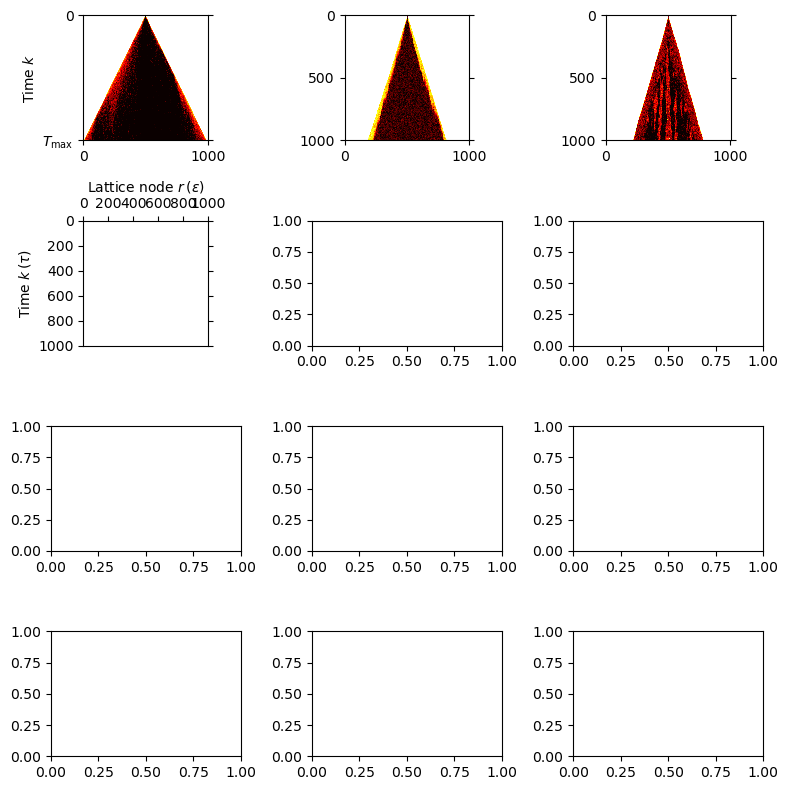

In [13]:
gs = gridspec.GridSpec(4, 3)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])
ax10 = fig.add_subplot(gs[3, 0])
ax11 = fig.add_subplot(gs[3, 1])
ax12 = fig.add_subplot(gs[3, 2])

plt.sca(ax1)
ax = ax1
lgca1.plot_density(absolute_max=100, figsize=figsize, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'Time $k$')
ax.set_yticks([0, 1000], [0, '$T_{\mathrm{max}}$'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')


plt.sca(ax2)
ax = ax2
lgca2.plot_density(absolute_max=100, figsize=figsize, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'')
# ax.set_yticks([0, 1000], ['', ''])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')

plt.sca(ax3)
ax = ax3
lgca3.plot_density(absolute_max=100, figsize=figsize, cbarlabel=r'Cell density $\rho$', cbar=False)
plt.ylabel(r'')
plt.xlabel(r'')
# ax.set_yticks([0, 1000], ['', ''])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

plt.sca(ax4)
ax = ax4
lgca1.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', figsize=figsize, cbar=False)
plt.ylabel(r'')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')
ax.set_yticks([0, 1000], [0, '$T_{\mathrm{max}}$'])


plt.sca(ax5)
ax = ax5
lgca2.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', figsize=figsize, cbar=False)
plt.ylabel(r'')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')
plt.yticks([0, 1000], ['', ''])

plt.sca(ax6)
ax = ax6
lgca3.plot_prop_spatial(propname='kappa', cbarlabel=r'Switch parameter $\kappa$', figsize=figsize, cbar=False)
plt.ylabel(r'')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('')
plt.yticks([0, 1000], ['', ''])

plt.setp(fig.axes, xlim=(0, constparams['l']), xticks=[0, 500, 1000], xticklabels=[])
plt.setp(fig.axes[:6], yticks=[0, 1000], yticklabels=[])
plt.setp(fig.axes[-3:], xticks=[0, 500, 1000], xticklabels=[0, r'$L/2$', r'$L$'])